# Capstone Project 2

## 

In [1]:
# Import Dependancies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load UsArrests Dataset

df = pd.read_csv('UsArrests.csv')

df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Preprocessing

In [3]:
# Get info on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


## Explore Data

In [4]:
# Get descriptive statistics
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Looking at the above data summary, the high variance between mean and standard deviation values for different variables shows the need for standardization of the data values. Assault stands out as having significantly higher mean and standard deviations in comparison to Murder. Assault has a mean value of 170.8 and murder a mean population of 7.78. We expect the PCA to perform poorly which such high differences in mean values accross features, and so the solution to this would be to create a scaled version of the data.

We will scale the data later on during the PCA.

array([[<AxesSubplot:title={'center':'Murder'}>,
        <AxesSubplot:title={'center':'Assault'}>],
       [<AxesSubplot:title={'center':'UrbanPop'}>,
        <AxesSubplot:title={'center':'Rape'}>]], dtype=object)

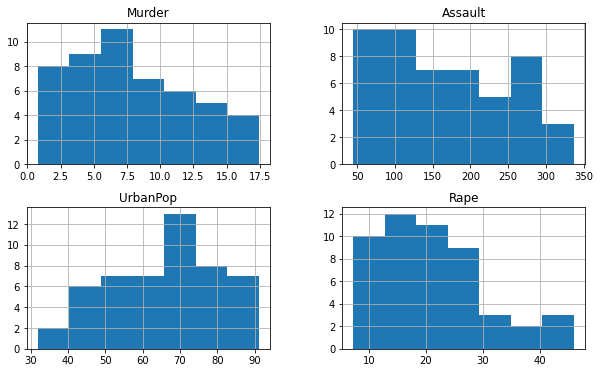

In [5]:
# Create histograms of ket attributes
df.hist(figsize=(10,6), bins=7)

We can see from the above histogram that all 3 crimes show a Poisson distribution. The distributions for Murder and assault look more similar and more uniform, while the distribution of rape cases looks more irregular. This makes sense as murder and assault are similar violent crimes with varying degree of intensity separating the crimes, while rape is a sexual crime, somewhat differentiating it from murder and assault. 

Assault statistics show one group which is an outlier in this pattern, at 8 cities with 250-300 cases. Rape shows that the majority of cities have been 0-30 cases, while a small minority have over 30 cases.

Urban population has a skewed left histogram, with most cities having populations over 6 000 000.


In [6]:
# Check for missing values
df.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [7]:
# Set city name as index
df = df.set_index('City')

## Correlation Analysis

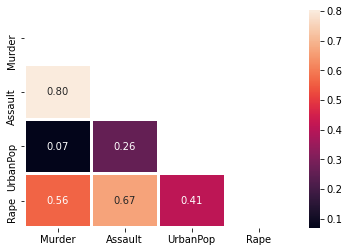

In [8]:
# Correlate unstandardized data
corr = df.corr()

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
ax = sns.heatmap(corr, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

plt.show()

The correlation heatmap above shows the correlations between all variables. The initial inspection indicates that there is postive correlation between assualt and murder case rate, an expected correlation seeing as they are both violent crimes. Murder and rape also have a positive correlation, but not one that is as strong as murder and assault. 

Interestingly, urban population has a weak positive correlation with all crimes, with correlations of 0.07, 0.26, and 0.41 for murder, assault, and rape respectively. This is in contrast to general ideas about bigger cities being more dangerous, crime ridden areas. Although weak, the correlations do exist and so this needs to be explored further using clustering, which may yield some clearer link.

No handles with labels found to put in legend.


Text(0, 0.5, 'Assault')

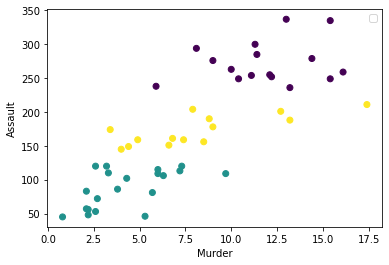

In [9]:
# Plot clusters using complete linkage
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
cluster.fit_predict(df)
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_)

# Add legend and labels
plt.legend()
plt.xlabel('Murder')
plt.ylabel('Assault')

The scatter plot above reveals three distinct city groups. The green represents cities with relatively low crime rates. The yellow cluster contains cities with moderate danger, and the purple cluster consists of high-danger cities. We can see that cities with higher assault rates tend to have higher murder rates, which is expected. 

This analysis only gives us the relationship between murder and assault, and so in order to simplify the analysis from multiple components, it would be best to standardize the data using Principle Component Analysis.

## Principal Component Analysis

### Unstandardised Data

In [10]:
# Choose the number of components to be generated
nr_comps = 2
unstandardizedModel = PCA(n_components=nr_comps)

# obtain components
principal_components = unstandardizedModel.fit_transform(df)

# transform the components into a pandas data frame
unstandardized_df = pd.DataFrame(principal_components, index=df.index)

# This is to include the country code as the rownames in the PC's
unstandardized_df.head()

,0,1
City,,
Alabama,64.802164,11.448007
Alaska,92.827450,17.982943
Arizona,124.068216,-8.830403
Arkansas,18.340035,16.703911
California,107.422953,-22.520070


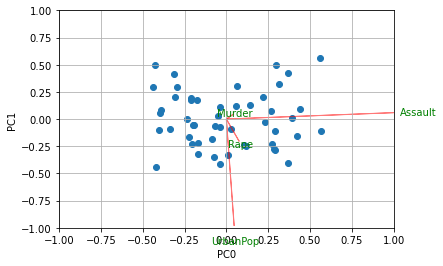

In [11]:
# Generate biplot
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs*scalex, ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df.columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(0))
    plt.ylabel("PC{}".format(1))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principal_components[:,0:2],np.transpose(unstandardizedModel.components_[0:2, :]))
plt.show()

Using the unstandardized data, we see that assault and murder have high relation to PC0, while PC1 dominated by Urban Population. The rape statistic has a relation to PC0, which is suprising given that it showed a strong correlation to the crime statitics rather than urban population in the correlation analysis. This may not create clear meaning in the clustering phase, and so we will standardize the data in hopes of solving this. 

### Standardised Data

In [13]:
# Standardize the data
X = StandardScaler().fit_transform(df.values)

# Choose the number of components to be generated
# We want the explained variance to be between 85% to 99%, and for this PCA, 85% is satisfactory.
nr_comps = 2
model = PCA(n_components=0.85)

# obtain components
principal_components = model.fit_transform(X)

# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, index=df.index)

# This is to include the country code as the rownames in the PC's
pca_df.head()

,0,1
City,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


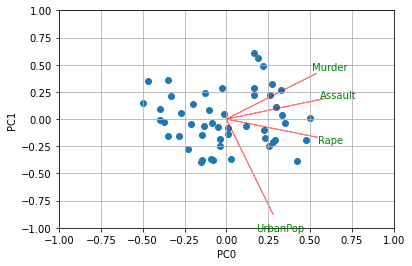

In [14]:
# Generate biplot
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df.columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(0))
    plt.ylabel("PC{}".format(1))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principal_components[:,0:2],np.transpose(model.components_[0:2, :]))
plt.show()

The above biplot shows the 50 cities plotted according to the 2 principal components. PC0 is dominated by the crime statistics, similarly to the unstandardized data, while PC1 is dominated by urban population. This means that the standardization step has helped and the generated clusters in the next step will have a more clear meaning. 

States with large positive scores among the first dimension (PC0) indicate states with high combined crime rates, while states with a large negative score have relatively low crime rates. 

It also appears that states with a large positive score for PC1 have lower urban population while states with a large negative score have larger populations. It does appear from PCA that cities with larger urban populations generally have higher crime rates, but the correlation is not strong.

We would like to separate the PCA into clusters.

## Cluster Analysis - Comparison of Two Methods

### Agglomerative heirarchical clustering



In order to decide on how best to split the data, we plot the various dendograms to decide on which method gives the most clear dispersion. 

In [15]:
X = pca_df.values.reshape(-1,2)

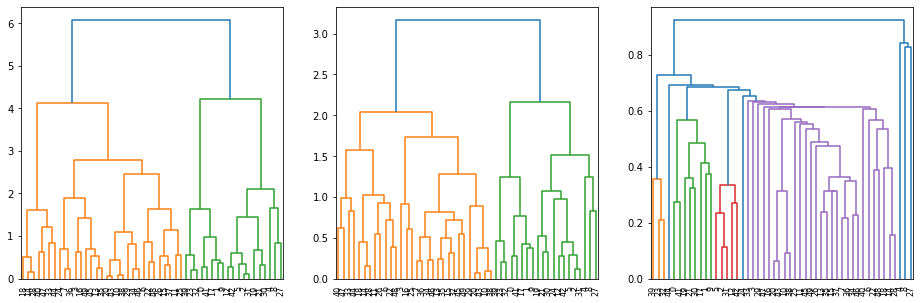

In [20]:
# Create Dendograms for Complete and Average links with Euclidean distance metrics
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16,5))
    
plt.subplot(1, 3, 1)
#ax1.set_title("Complete linkage based Dendograms with Euclidean distance metric")  
dend_1 = dendrogram(linkage(X, method='complete'))

plt.subplot(1, 3, 2)
#ax2.set_title("Average linkage based Dendograms with Euclidean distance metric")  
dend_2 = dendrogram(linkage(X, method='average'))  

plt.subplot(1, 3, 3)
#ax3.set_title("Single linkage based Dendograms with Euclidean distance metric")  
dend_3 = dendrogram(linkage(X, method='single'))  

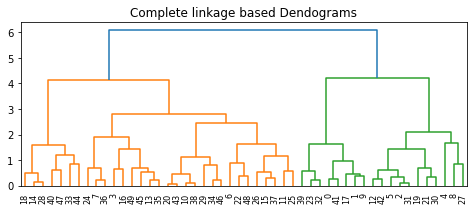

In [21]:
# Generate more clear dendogram
plt.figure(figsize=(8, 3))
plt.title("Complete linkage based Dendograms")  
dend = dendrogram(linkage(X, method='complete'))  

The hierchical clustering using the complete method splits the PCA data best, into 4 distinct groups if taken at the level L=3. The complete method with k=4 splits the data into 4 groups consisting of 8, 21, 11, and 8 points respectively. The low crime, high population group is the largest group with 21 points. Let's visualize this in a scatter plot.

Text(0, 0.5, 'PC1')

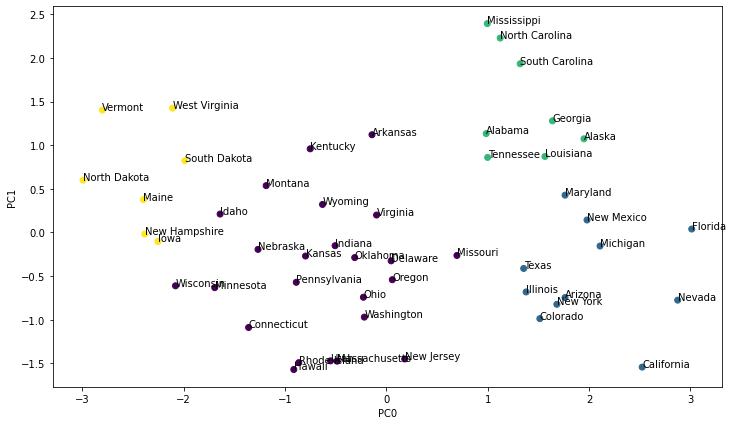

In [18]:
#Perform aglomerative clustering on PCA results
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster.fit_predict(pca_df)
fig, ax = plt.subplots(figsize=(12, 7))
plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], c=cluster.labels_)

# Annotate and label graph
for x, y in pca_df.iterrows():
   ax.annotate(x, y)
plt.xlabel('PC0')
plt.ylabel('PC1')

Here we have generated a scatter plot of the prinicple components using agglomerative hierchical clustering. The 4 clusters can be clearly seen. The 4 groups represent low population / low crime (yellow), high population / low crime (purple), low population / high crime (green), and high population / high crime (blue). 

High population / low crime (purple) is the largest group, and low population / low crime is tied for the fewest data points along with low population / high crime at 8 points.

### K-Means

Text(0, 0.5, 'PC1')

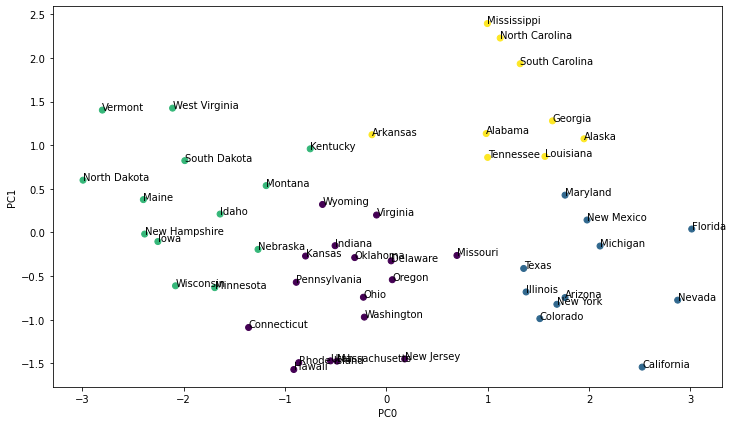

In [19]:
# prepare data for training
x = pca_df.values

# Create K-Means model
kmeans = KMeans(n_clusters=4, random_state=4)
y_pred = kmeans.fit_predict(x)

# Plot K-means model
fig, ax = plt.subplots(figsize=(12, 7))
plt.scatter(pca_df[0], pca_df[1], c=y_pred)

# Annotate and label graph
for x, y in pca_df.iterrows():
   ax.annotate(x, y)
plt.xlabel('PC0')
plt.ylabel('PC1')

The 4 clusters that were generated using K-means are similar to those generated by agglomerative hierchical clustering.

The blue cluster here are cities classified as high population / high crime cities. 
The yellow cluster represents cities with low population / high crime
The green cluster contains cities  with low population / low crime
The purple cluster contains cities  with high population / low crime

There are several differences in the clusters generated from K-means compared to those generated by agglomerative hierchical clustering. The first noticible difference is that the high population/low crime group (purple) is smaller from K-means, with Idaho, Kentucky, Montana, Nebraska, Minesota, and Wisconsin now considered to be part of the low population / low crime group. 

Arkansas is now considered among the low population / high crime group, which seems innacurate. It looks more closely related to either the green or purple group. While the distribution among clusters seems distinct for both K-Means and agglomerative clustering, the clusters generated by agglomerative clustering seem more accurate.

This cluster analysis has helped us to categorize cities level of danger as well as identify a relationship between city size and general violent crime.